In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
import warnings

In [2]:
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_theme()

Load & Visualize the Data:

Use yfinance (or a comparable library) to download historical time series data.

Plot the raw closing prices and calculate daily returns to gain insight into trend and volatility.

In [3]:
# Download S&P 500 data for the last 10 years
sp500 = yf.download('^GSPC', start='2013-01-01', end='2022-12-31')


# Display the first few rows of the dataset
print("S&P 500 Dataset:")
print(sp500.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

S&P 500 Dataset:
Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2013-01-02  1462.420044  1462.430054  1426.189941  1426.189941  4202600000
2013-01-03  1459.369995  1465.469971  1455.530029  1462.420044  3829730000
2013-01-04  1466.469971  1467.939941  1458.989990  1459.369995  3424290000
2013-01-07  1461.890015  1466.469971  1456.619995  1466.469971  3304970000
2013-01-08  1457.150024  1461.890015  1451.640015  1461.890015  3601600000


In [4]:
# Display basic information about the dataset
print("\nDataset information:")
print(sp500.info())



Dataset information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2518 entries, 2013-01-02 to 2022-12-30
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Close, ^GSPC)   2518 non-null   float64
 1   (High, ^GSPC)    2518 non-null   float64
 2   (Low, ^GSPC)     2518 non-null   float64
 3   (Open, ^GSPC)    2518 non-null   float64
 4   (Volume, ^GSPC)  2518 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 118.0 KB
None


In [5]:
# Calculate basic summary statistics
print("\nSummary Statistics:")
print(sp500['Close'].describe())


Summary Statistics:
Ticker        ^GSPC
count   2518.000000
mean    2742.695377
std      872.793493
min     1457.150024
25%     2050.752441
50%     2584.900024
75%     3275.690002
max     4796.560059


In [6]:
# Check for missing values
print("\nMissing values in each column:")
print(sp500.isnull().sum())


Missing values in each column:
Price   Ticker
Close   ^GSPC     0
High    ^GSPC     0
Low     ^GSPC     0
Open    ^GSPC     0
Volume  ^GSPC     0
dtype: int64


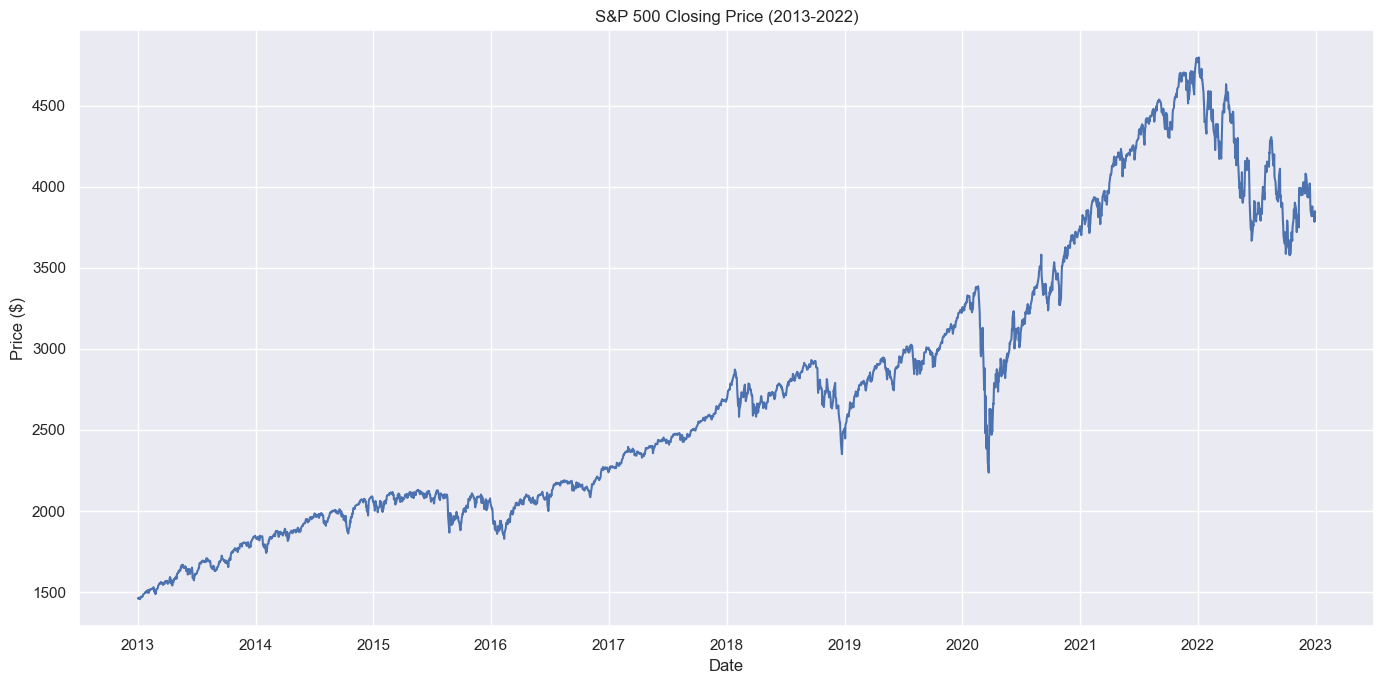

In [7]:
# Plot the closing price
plt.figure(figsize=(14, 7))
plt.plot(sp500.index, sp500['Close'])
plt.title('S&P 500 Closing Price (2013-2022)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# Select the closing price as our primary time series for analysis
ts_data = sp500['Close']
print("\nSelected time series shape:", ts_data.shape)


Selected time series shape: (2518, 1)


Check Stationarity & Apply Transformations:

Perform rolling statistics and the Augmented Dickey-Fuller test to see if the series is stationary.

If needed, apply log transformations or differencing to stabilize trends and variance.

In [9]:
# Rolling mean and standard deviation
rolling_mean = ts_data.rolling(90).mean()
rolling_std = ts_data.rolling(90).std()

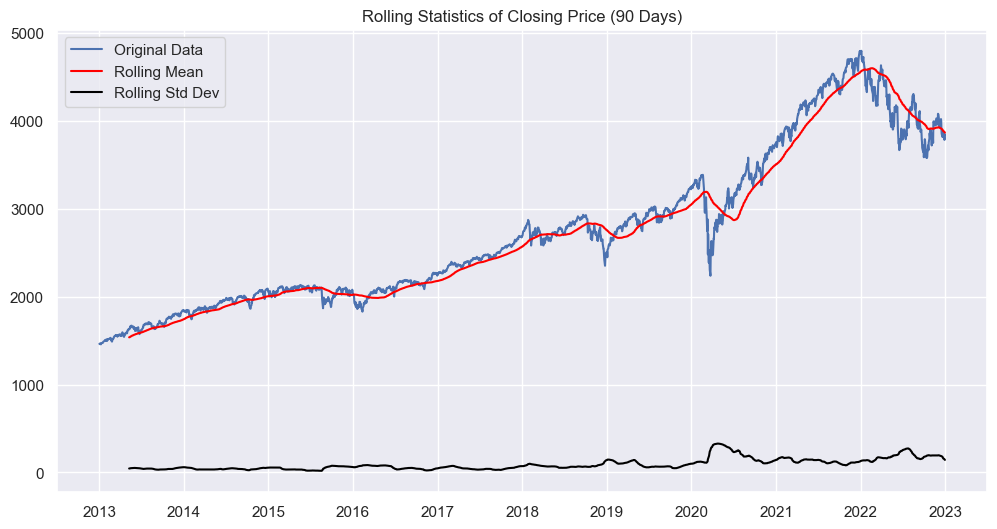

In [10]:
# Plot the Rollsing Statistics

plt.figure(figsize=(12, 6))
plt.plot(ts_data, label='Original Data')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std Dev', color='black')
plt.legend()
plt.title("Rolling Statistics of Closing Price (90 Days)")
plt.show()

In [11]:
# Test original data
result = adfuller(ts_data.dropna())
print("p-value:", result[1])

p-value: 0.7417120357643822


High p-value suggest that we do not have a stationary data set.

In [28]:
# Transform if non-stationary
ts_log = np.log(ts_data)
result = adfuller(ts_log.dropna())
print("p-value:", result[1])


p-value: 0.5768203745646303


In [29]:
ts_log_diff = ts_log.diff().dropna()
result = adfuller(ts_log_diff.dropna())
print("p-value:", result[1])

p-value: 9.782658846190978e-29


Much better.

Decompose & Diagnose Patterns:

Decompose your time series into trend, seasonal, and residual components.

Confirm whether seasonal patterns exist (e.g., monthly or quarterly cycles).

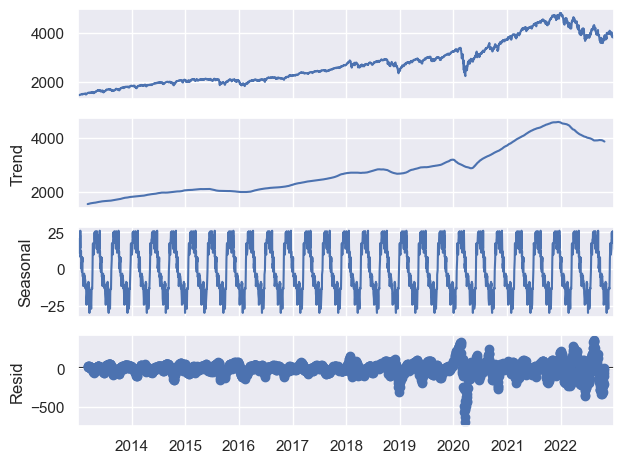

In [14]:
composition = seasonal_decompose(ts_data,period=90)
composition.plot()
plt.show()

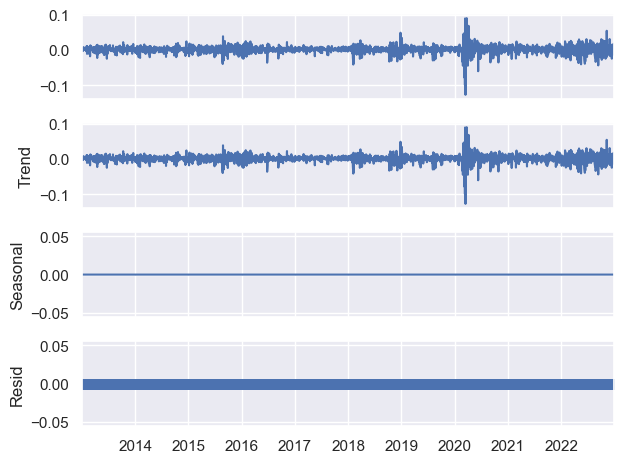

In [15]:
composition = seasonal_decompose(ts_log_diff,period=1)
composition.plot()
plt.show()

# Model Selection & Forecasting:

Reference ACF/PACF plots to choose between AR, MA, ARMA, or ARIMA models.

Fit multiple models, compare performance (e.g., via AIC/BIC), and pick the best.

Use forecasting functions to project future values, then evaluate prediction accuracy (MAE, RMSE, MAPE).

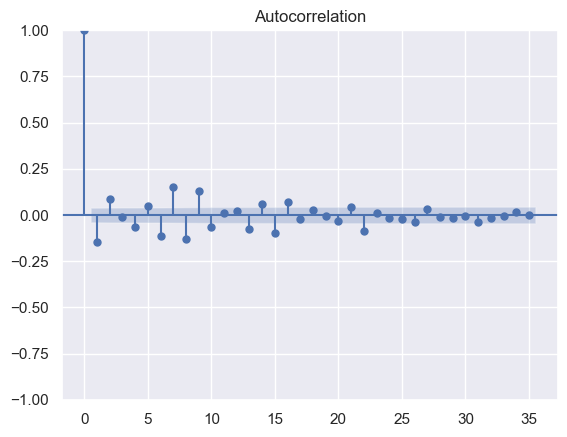

In [16]:
plot_acf(ts_log_diff)
plt.show()

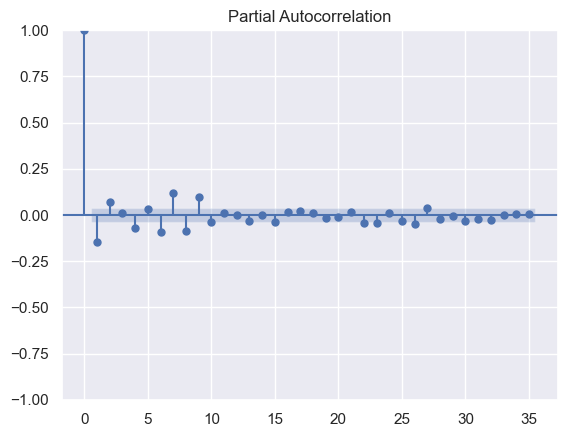

In [17]:
plot_pacf(ts_log_diff)
plt.show()

Try AR(1)

In [18]:
model = ARIMA(ts_log_diff, order=(1,0,0))
model_fit = model.fit()
print(model_fit.summary())
print(model_fit.aic,model_fit.bic)

                               SARIMAX Results                                
Dep. Variable:                  ^GSPC   No. Observations:                 2517
Model:                 ARIMA(1, 0, 0)   Log Likelihood                7780.893
Date:                Sat, 17 May 2025   AIC                         -15555.786
Time:                        14:50:03   BIC                         -15538.293
Sample:                             0   HQIC                        -15549.437
                               - 2517                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.904      0.057   -1.13e-05       0.001
ar.L1         -0.1457      0.007    -19.636      0.000      -0.160      -0.131
sigma2         0.0001   1.31e-06     92.430      0.0

Try MA(1)

In [19]:
model = ARIMA(ts_log_diff, order=(0,0,1))
model_fit = model.fit()
print(model_fit.summary())
print(model_fit.aic,model_fit.bic)

                               SARIMAX Results                                
Dep. Variable:                  ^GSPC   No. Observations:                 2517
Model:                 ARIMA(0, 0, 1)   Log Likelihood                7777.297
Date:                Sat, 17 May 2025   AIC                         -15548.595
Time:                        14:50:03   BIC                         -15531.102
Sample:                             0   HQIC                        -15542.246
                               - 2517                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.851      0.064   -2.23e-05       0.001
ma.L1         -0.1268      0.008    -15.709      0.000      -0.143      -0.111
sigma2         0.0001   1.29e-06     94.036      0.0

Let's build an ARMA(1,1) model since that fits the ACF and PACF plots.

In [38]:
model = ARIMA(ts_log_diff, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())
print(model_fit.aic,model_fit.bic)

                               SARIMAX Results                                
Dep. Variable:                  ^GSPC   No. Observations:                 2517
Model:                 ARIMA(1, 1, 1)   Log Likelihood                7772.733
Date:                Sat, 17 May 2025   AIC                         -15539.467
Time:                        14:59:21   BIC                         -15521.975
Sample:                             0   HQIC                        -15533.119
                               - 2517                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1458      0.007    -19.662      0.000      -0.160      -0.131
ma.L1         -1.0000      0.101     -9.947      0.000      -1.197      -0.803
sigma2         0.0001   1.19e-05     10.159      0.0

In [21]:
forecast = model_fit.forecast(steps=120)
forecast_exp = np.exp(forecast)
forecast

2517    0.001781
2518   -0.000313
2519    0.000730
2520    0.000210
2521    0.000469
          ...   
2632    0.000383
2633    0.000383
2634    0.000383
2635    0.000383
2636    0.000383
Name: predicted_mean, Length: 120, dtype: float64

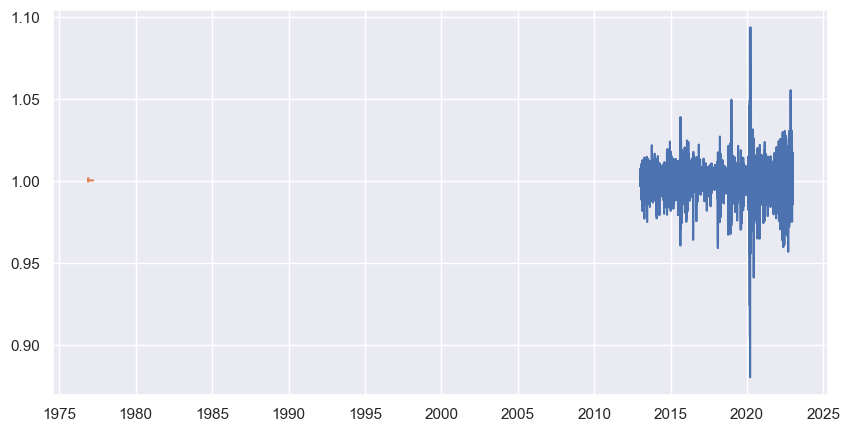

In [22]:
# Plot forecasts
plt.figure(figsize=(10,5))
plt.plot(ts_log_diff.apply(np.exp),label='Observed')
plt.plot(forecast_exp,label='Forecast');

In [23]:
# Get in-sample predictions
# Get predictions for the original time series range
predictions = model_fit.predict() 


# Calculate error metrics
mae = abs(model_fit.resid).sum()
rmse = (model_fit.resid**2).sum()

mae, rmse

(17.94796397621377, 0.30361794227646355)

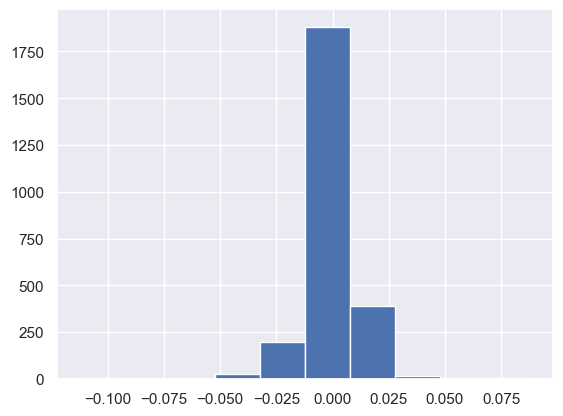

In [27]:
plt.hist(model_fit.resid);

In [41]:
model_2 = ARIMA(ts_log_diff, order=(2,0,2))
model_fit_2 = model_2.fit()
print(model_fit_2.summary())
print(model_fit_2.aic,model_fit_2.bic)

                               SARIMAX Results                                
Dep. Variable:                  ^GSPC   No. Observations:                 2517
Model:                 ARIMA(2, 0, 2)   Log Likelihood                7786.824
Date:                Sat, 17 May 2025   AIC                         -15561.648
Time:                        15:00:50   BIC                         -15526.663
Sample:                             0   HQIC                        -15548.951
                               - 2517                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.682      0.093    -6.3e-05       0.001
ar.L1         -0.4481      0.471     -0.952      0.341      -1.370       0.474
ar.L2         -0.0502      0.247     -0.203      0.8

In [42]:
forecast = model_fit_2.forecast(steps=120)
forecast_exp = np.exp(forecast)
forecast

2517    0.002064
2518   -0.000214
2519    0.000563
2520    0.000329
2521    0.000395
          ...   
2632    0.000381
2633    0.000381
2634    0.000381
2635    0.000381
2636    0.000381
Name: predicted_mean, Length: 120, dtype: float64

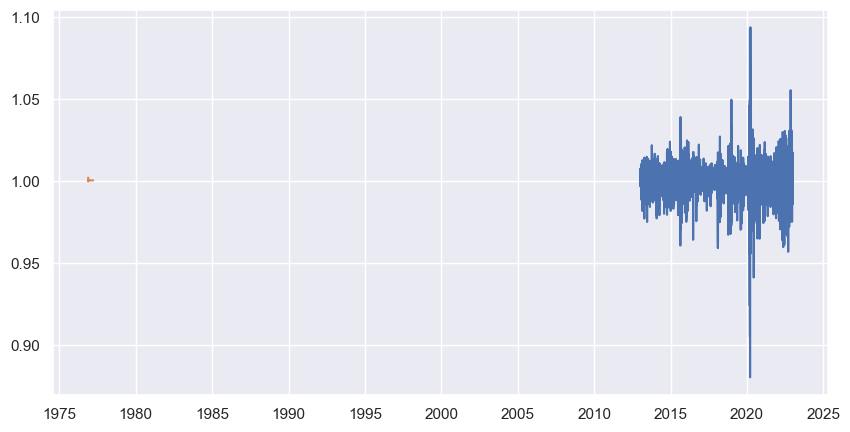

In [43]:
# Plot forecasts
plt.figure(figsize=(10,5))
plt.plot(ts_log_diff.apply(np.exp),label='Observed')
plt.plot(forecast_exp,label='Forecast');

In [44]:
# Get in-sample predictions
# Get predictions for the original time series range
predictions = model_fit_2.predict() 


# Calculate error metrics
mae = abs(model_fit_2.resid).sum()
rmse = (model_fit_2.resid**2).sum()

mae, rmse

(17.942302570252956, 0.30287017826437784)

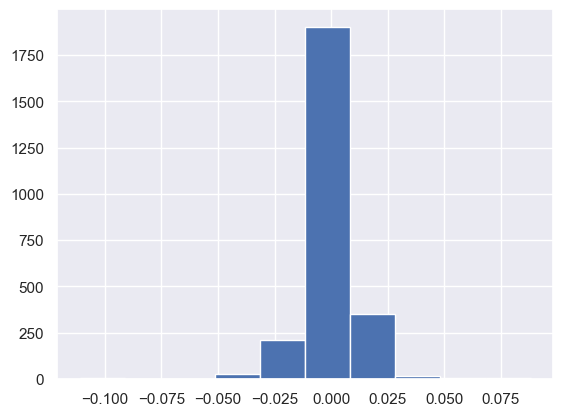

In [45]:
plt.hist(model_fit_2.resid);